<div style="text-align: center;">

# Matrix Monitoring for Accelerating Frequent Pattern Mining

</div>

**Notebook:** `CDM__1_Final.ipynb`  

**Project Goal:** Investigate matrix sketching and monitoring methods—specifically GRP, IPCA, SpFD, and SpEmb—and evaluate their impact on frequent pattern mining algorithms (FP-Growth).

**Abstract:** This notebook loads the Online Retail dataset, constructs a binary item–transaction matrix, and applies several matrix sketching techniques to compress the transaction matrix. We then compare the runtime, reconstruction quality, and pattern similarity of frequent itemset mining on the original versus the compressed matrices. Evaluation metrics include reconstruction error (relative Frobenius norm), execution time, and similarity of discovered itemsets.

In [1]:
# -----------------------------------------------------------
# Core Libraries
# -----------------------------------------------------------
import pandas as pd                # Data manipulation and analysis
import numpy as np                 # Numerical operations
import matplotlib.pyplot as plt    # Plotting and visualization
import time                        # Timing operations
import copy                        # Deep copy utility
from tqdm import tqdm              # Progress bars for loops

# -----------------------------------------------------------
# Linear Algebra Utilities
# -----------------------------------------------------------
from numpy.linalg import svd, qr  # Singular Value Decomposition and QR decomposition

# -----------------------------------------------------------
# Frequent Pattern Mining
# -----------------------------------------------------------
from mlxtend.frequent_patterns import fpgrowth  # FP-Growth algorithm for frequent itemsets

# -----------------------------------------------------------
# Optional: Incremental PCA (TFPCA)
# -----------------------------------------------------------
# The notebook references tfpca package for incremental PCA.
# If not installed, this block will catch the error and print a warning.
# Reference: https://github.com/lukassnoek/tf-incremental-pca
try:
    from tfpca import TFIncrementalPCA  # Incremental PCA implementation
except Exception as e:
    print("Warning: tfpca not available. If using incremental PCA, install tfpca. Error:", e)

try:
    import tensorflow as tf  # TensorFlow
except Exception as e:
    print("Warning: TensorFlow not available. Install tensorflow to use. Error:", e)

# -----------------------------------------------------------
# Suppress Warnings
# -----------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")  # Ignore unnecessary warnings for cleaner output

In [2]:
# -----------------------------------------------------------
# Load the Online Retail Dataset
# -----------------------------------------------------------
# Adjust the file path if needed. 
# For large datasets, consider loading a subset during development to speed up testing.

df = pd.read_csv(
    'Online Retail.csv',   # Path to the CSV file
    encoding='latin1'      # Encoding may vary depending on the dataset
)

# Print basic info about the dataset
print("Raw data shape:", df.shape)

Raw data shape: (541909, 8)


In [3]:
# -----------------------------------------------------------
# Inspect the dataset
# -----------------------------------------------------------

# Display the first few rows to understand the structure and sample data
display(df.head())

# Show a concise summary of the DataFrame:
# - Column names and types
# - Number of non-null entries
# - Memory usage
df.info()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# -----------------------------------------------------------
# Data Cleaning
# -----------------------------------------------------------

# Convert 'InvoiceDate' column to datetime format
# 'errors="coerce"' will convert invalid dates to NaT
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Basic cleaning steps:
# 1. Drop missing values (NaNs)
# 2. Remove duplicate rows
df_clean = df.dropna().drop_duplicates().copy()

# 3. Keep only positive quantities or positive unit prices
#    This removes returns or negative transactions
df_clean = df_clean[(df_clean['Quantity'] > 0) | (df_clean['UnitPrice'] > 0)]

# 4. Remove cancelled transactions
#    Invoice numbers starting with 'C' indicate cancellations
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# 5. Optionally restrict StockCode to typical product codes
#    Keep codes that are 1-5 digits possibly followed by an uppercase letter
df_clean = df_clean[df_clean['StockCode'].astype(str).str.match(r'^\d{1,5}[A-Z]?$')]

# Show the shape of the cleaned dataset
print("Cleaned data shape:", df_clean.shape)

# Display first few rows of the cleaned data
display(df_clean.head())

Cleaned data shape: (390892, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# -----------------------------------------------------------
# Build Item-Transaction Matrix
# -----------------------------------------------------------
# Rows represent transactions (InvoiceNo)
# Columns represent items (StockCode)
# Values indicate presence (1) or absence (0) of an item in a transaction

# Step 1: Group by InvoiceNo and StockCode, count occurrences
item_transaction_matrix = df_clean.groupby(['InvoiceNo', 'StockCode']).size().unstack(fill_value=0)

# Step 2: Convert counts to binary (1 = item present, 0 = item absent)
item_transaction_matrix = (item_transaction_matrix > 0).astype(float)

# Show matrix shape and first few rows
print("Item-transaction matrix shape:", item_transaction_matrix.shape)
display(item_transaction_matrix.head())

Item-transaction matrix shape: (18404, 3658)


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214O,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# -----------------------------------------------------------
# Inspect Transaction Date Ranges
# -----------------------------------------------------------
# Useful for understanding the time span of transactions,
# especially when planning to split data into batches.

# Create a DataFrame of unique invoices with their dates
invoice_dates = df_clean[['InvoiceNo', 'InvoiceDate']].drop_duplicates().set_index('InvoiceNo')

# Show the overall date range of transactions
print(
    "Transaction date range:",
    invoice_dates['InvoiceDate'].min(),  # Earliest invoice date
    "to",
    invoice_dates['InvoiceDate'].max()   # Latest invoice date
)

Transaction date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [7]:
# -----------------------------------------------------------
# Split the transaction matrix into time-ordered batches
# -----------------------------------------------------------

# Create an ordered list of invoices sorted by invoice date
invoice_order = (
    df_clean[['InvoiceNo', 'InvoiceDate']]
    .drop_duplicates()         # Remove duplicate invoice entries
    .sort_values('InvoiceDate') # Sort invoices chronologically
)

# Reorder the transaction matrix rows to match the sorted invoices
item_transaction_matrix = item_transaction_matrix.loc[invoice_order['InvoiceNo']]

# -----------------------------------------------------------
# Divide the transaction matrix into N sequential batches
# -----------------------------------------------------------
n_batches = 10  # Number of batches to create
batch_size = len(item_transaction_matrix) // n_batches  # Size of each batch (approximately equal)

batches = []  # List to store batch DataFrames

for i in range(n_batches):
    # Compute start and end indices for the batch
    start = i * batch_size
    end = (i + 1) * batch_size if i < n_batches - 1 else len(item_transaction_matrix)
    
    # Extract the batch from the transaction matrix
    batch_df = item_transaction_matrix.iloc[start:end]
    batches.append(batch_df)
    
    # Extract corresponding invoice subset for date information
    invoice_subset = invoice_order.iloc[start:end]
    start_date = invoice_subset['InvoiceDate'].min()
    end_date = invoice_subset['InvoiceDate'].max()
    
    # Print summary information for each batch
    print(f"Batch {i+1}: shape={batch_df.shape}, from {start_date} to {end_date}")

Batch 1: shape=(1843, 3658), from 2010-12-01 08:26:00 to 2011-01-16 13:54:00
Batch 2: shape=(1843, 3658), from 2011-01-16 14:36:00 to 2011-03-08 14:47:00
Batch 3: shape=(1843, 3658), from 2011-03-08 15:03:00 to 2011-04-19 16:31:00
Batch 4: shape=(1843, 3658), from 2011-04-19 16:37:00 to 2011-05-31 14:14:00
Batch 5: shape=(1843, 3658), from 2011-05-31 14:14:00 to 2011-07-12 11:15:00
Batch 6: shape=(1843, 3658), from 2011-07-12 11:16:00 to 2011-08-23 13:30:00
Batch 7: shape=(1843, 3658), from 2011-08-23 13:35:00 to 2011-09-28 13:23:00
Batch 8: shape=(1843, 3658), from 2011-09-28 13:30:00 to 2011-10-27 14:27:00
Batch 9: shape=(1843, 3658), from 2011-10-27 14:38:00 to 2011-11-18 13:02:00
Batch 10: shape=(1847, 3658), from 2011-11-18 13:14:00 to 2011-12-09 12:50:00


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


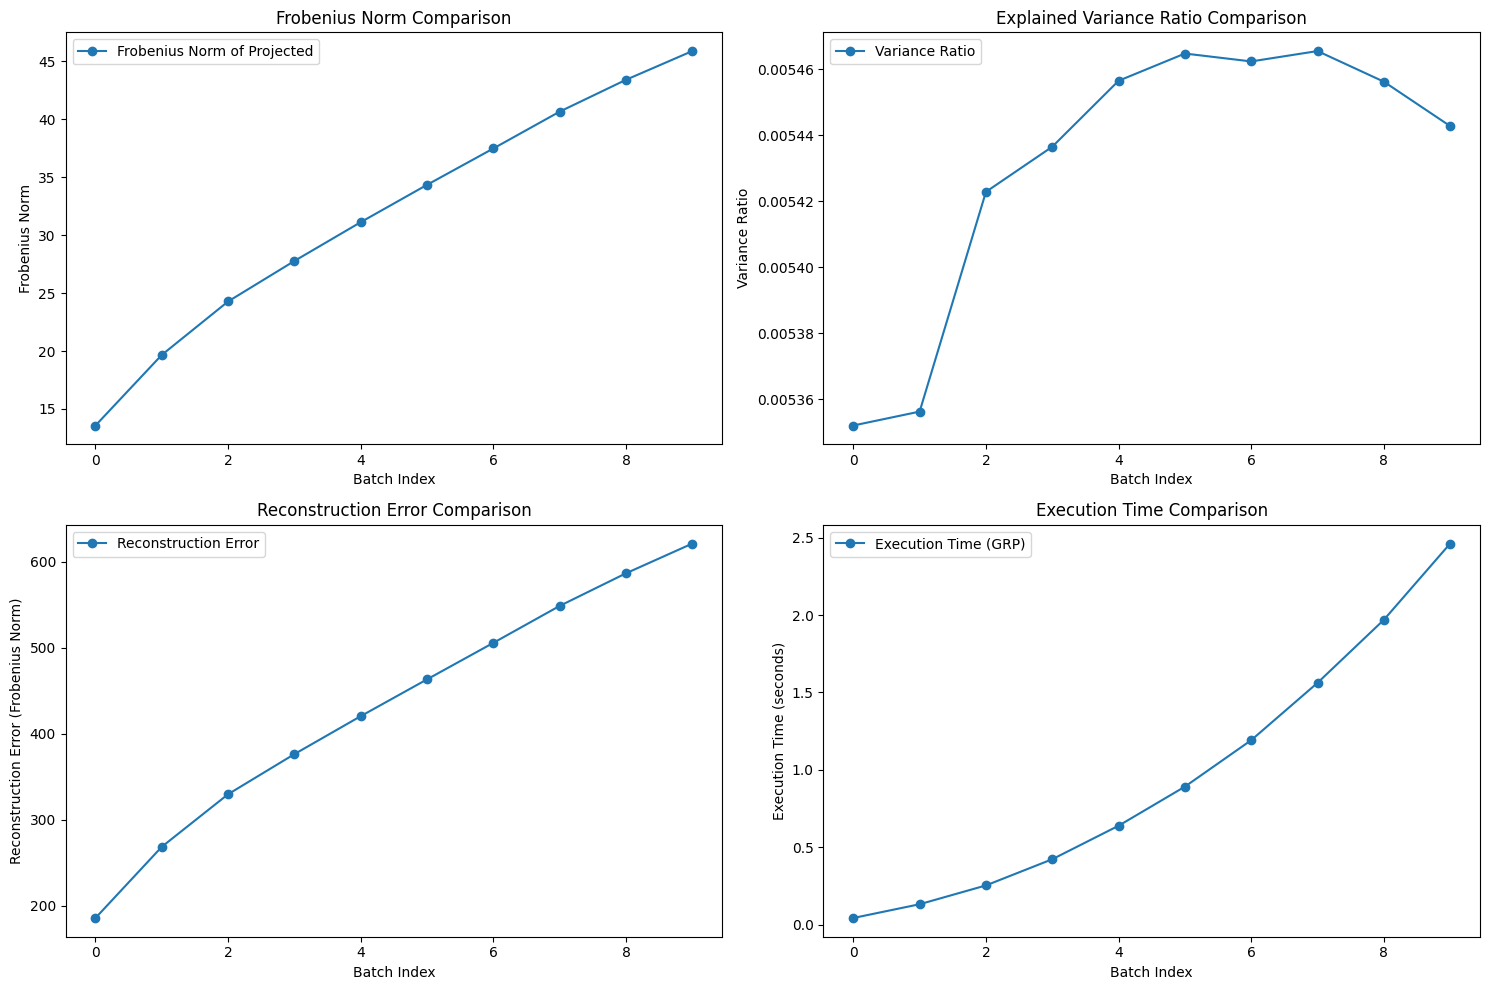

In [8]:
# -----------------------------------------------------------
# Gaussian Random Projection on Transaction Batches
# -----------------------------------------------------------

n_features = batches[0].shape[1]  # Number of items (columns)
K_DIM = 20  # Target dimension for projection

def gaussian_random_projection(A, k=K_DIM):
    """
    Apply Gaussian Random Projection to reduce dimensionality of matrix A.

    Parameters:
    -----------
    A : np.ndarray or pd.DataFrame
        Input data matrix (rows = transactions, columns = items)
    k : int
        Target number of dimensions for projection

    Returns:
    --------
    A_sketched : np.ndarray
        Projected matrix of shape (n_samples, k)
    reconstructed : np.ndarray
        Approximate reconstruction of the original matrix (n_samples, n_features)
    """
    np.random.seed(2020)  # Ensure reproducibility
    
    n, d = A.shape
    # Gaussian random matrix for projection
    gaussian_random_matrix = np.random.normal(0, 1/np.sqrt(k), (d, k))
    
    # Orthogonalize the random matrix using QR decomposition
    Q = np.linalg.qr(gaussian_random_matrix)[0]
    
    # Project original data
    A_sketched = A @ Q
    
    # Reconstruct approximate original data
    reconstructed = A_sketched @ Q.T
    
    return A_sketched, reconstructed


# -----------------------------------------------------------
# Initialize lists to store results
# -----------------------------------------------------------
projected_grp = []      # Projected data
reconstructed_grp = []  # Reconstructed data
fro_norms_grp = []      # Frobenius norm of projected data
var_ratios_grp = []     # Explained variance ratio
rec_errors_grp = []     # Reconstruction error
times_grp = []          # Cumulative execution time

cumulative_data = None  # Stack batches incrementally
i = 0

# -----------------------------------------------------------
# Process each batch
# -----------------------------------------------------------
for batch_index, batch_data in enumerate(tqdm(batches)):
    # Stack batches cumulatively
    if cumulative_data is None:
        cumulative_data = batch_data
    else:
        cumulative_data = np.vstack((cumulative_data, batch_data))
    
    # Start timer
    start_time = time.time()
    
    # Apply Gaussian Random Projection
    projected, reconstructed = gaussian_random_projection(cumulative_data, k=K_DIM)
    
    # Store results
    projected_grp.append(projected)
    reconstructed_grp.append(reconstructed)
    
    # End timer and record cumulative execution time
    end_time = time.time()
    if len(times_grp) > 0:
        times_grp.append((end_time - start_time) + times_grp[-1])
    else:
        times_grp.append(end_time - start_time)
    
    # Compute reconstruction error (Frobenius norm)
    if i == 0:
        rec_error = np.linalg.norm(cumulative_data.values - reconstructed.values, 'fro') 
    else:
        rec_error = np.linalg.norm(cumulative_data - reconstructed, 'fro') 
    
    i += 1
    
    # Compute explained variance ratio
    total_var = np.sum(np.var(cumulative_data, axis=0))
    projected_var = np.sum(np.var(projected, axis=0))
    var_ratio = projected_var / total_var
    
    # Frobenius norm of original batch and projected batch
    fro_norm_main = np.linalg.norm(batch_data, 'fro')
    fro_norm_por = np.linalg.norm(projected, 'fro')
    
    # Store metrics
    fro_norms_grp.append(fro_norm_por)
    var_ratios_grp.append(var_ratio)
    rec_errors_grp.append(rec_error)

# -----------------------------------------------------------
# Plot Results
# -----------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Frobenius norm comparison
axs[0][0].plot(range(len(batches)), fro_norms_grp, 'o-', label='Frobenius Norm of Projected')
axs[0][0].set_title('Frobenius Norm Comparison')
axs[0][0].set_xlabel('Batch Index')
axs[0][0].set_ylabel('Frobenius Norm')
axs[0][0].legend()

# Explained variance ratio
axs[0][1].plot(range(len(batches)), var_ratios_grp, 'o-', label='Variance Ratio')
axs[0][1].set_title('Explained Variance Ratio Comparison')
axs[0][1].set_xlabel('Batch Index')
axs[0][1].set_ylabel('Variance Ratio')
axs[0][1].legend()

# Reconstruction error
axs[1][0].plot(range(len(batches)), rec_errors_grp, 'o-', label='Reconstruction Error')
axs[1][0].set_title('Reconstruction Error Comparison')
axs[1][0].set_xlabel('Batch Index')
axs[1][0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axs[1][0].legend()

# Execution time
axs[1][1].plot(range(len(batches)), times_grp, 'o-', label='Execution Time (GRP)')
axs[1][1].set_title('Execution Time Comparison')
axs[1][1].set_xlabel('Batch Index')
axs[1][1].set_ylabel('Execution Time (seconds)')
axs[1][1].legend()

plt.tight_layout()
plt.show()

100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


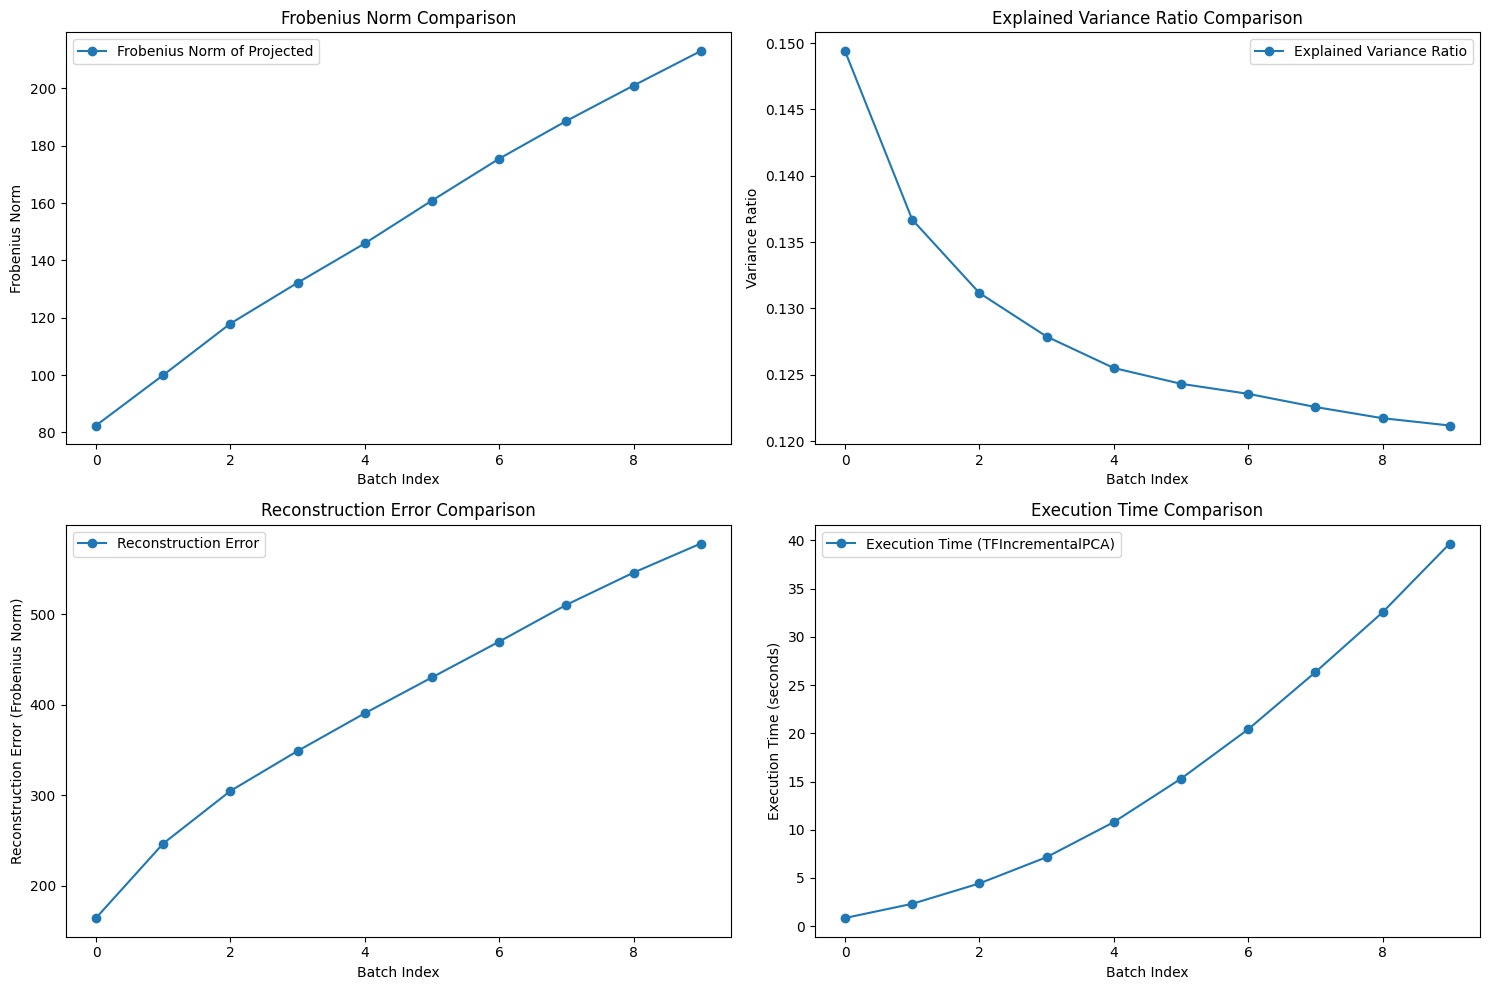

In [9]:
# -----------------------------------------------------------
# TensorFlow Incremental PCA (TFIncrementalPCA) on Transaction Batches
# -----------------------------------------------------------

# Convert each batch to a TensorFlow constant
tf_batches = [tf.constant(batch_data, dtype=tf.float32) for batch_data in batches]

# Number of features (items) and number of principal components
n_features = tf_batches[0].shape[1]
n_comp = 20  # Target number of PCA components
batch_size = 200  # Mini-batch size for incremental updates

# Initialize the TFIncrementalPCA object
pca_tf = TFIncrementalPCA(n_components=n_comp)

# -----------------------------------------------------------
# Initialize lists to store results
# -----------------------------------------------------------
projected_ipca = []      # Projected data
reconstructed_ipca = []  # Reconstructed data
fro_norms_ipca = []      # Frobenius norm of projected data
var_ratios_ipca = []     # Explained variance ratio
rec_errors_ipca = []     # Reconstruction error
times_ipca = []          # Cumulative execution time

cumulative_data = None

# -----------------------------------------------------------
# Process each batch
# -----------------------------------------------------------
for batch_index, batch_data_tf in enumerate(tqdm(tf_batches)):
    # Stack batches cumulatively
    if cumulative_data is None:
        cumulative_data = batch_data_tf.numpy()
    else:
        cumulative_data = np.vstack((cumulative_data, batch_data_tf.numpy()))
    
    # Create a TensorFlow Dataset for mini-batch incremental PCA
    dataset = tf.data.Dataset.from_tensor_slices(cumulative_data).batch(batch_size)

    projected_tf = []
    reconstructed_tf = []
    
    # Start timing
    start_time = time.time()
    
    # Incremental fit for each mini-batch
    for batch in dataset:
        pca_tf.partial_fit(batch)
        projected_tf.append(pca_tf.transform(batch))
        reconstructed_tf.append(pca_tf.inverse_transform(projected_tf[-1]))
    
    # Concatenate results across mini-batches
    projected_tf = tf.concat(projected_tf, axis=0)
    reconstructed_tf = tf.concat(reconstructed_tf, axis=0)
    
    # End timing
    end_time = time.time()
    
    # Cumulative execution time
    if len(times_ipca) > 0:
        times_ipca.append((end_time - start_time) + times_ipca[-1])
    else:
        times_ipca.append(end_time - start_time)
    
    # Store projected and reconstructed arrays
    projected_ipca.append(projected_tf.numpy())
    reconstructed_ipca.append(reconstructed_tf.numpy())

    # Compute reconstruction error (Frobenius norm)
    rec_error = np.linalg.norm(cumulative_data - reconstructed_tf, 'fro')
    # Compute explained variance ratio
    var_ratio = pca_tf.explained_variance_ratio_.numpy().sum()
    
    # Frobenius norm of projected data
    fro_norm_por = np.linalg.norm(projected_tf.numpy(), 'fro')
    
    # Append metrics to lists
    fro_norms_ipca.append(fro_norm_por)
    var_ratios_ipca.append(var_ratio)
    rec_errors_ipca.append(rec_error)

# -----------------------------------------------------------
# Plot Results
# -----------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Frobenius norm of projected data
axs[0][0].plot(range(len(tf_batches)), fro_norms_ipca, 'o-', label='Frobenius Norm of Projected')
axs[0][0].set_title('Frobenius Norm Comparison')
axs[0][0].set_xlabel('Batch Index')
axs[0][0].set_ylabel('Frobenius Norm')
axs[0][0].legend()

# Explained variance ratio
axs[0][1].plot(range(len(tf_batches)), var_ratios_ipca, 'o-', label='Explained Variance Ratio')
axs[0][1].set_title('Explained Variance Ratio Comparison')
axs[0][1].set_xlabel('Batch Index')
axs[0][1].set_ylabel('Variance Ratio')
axs[0][1].legend()

# Reconstruction error
axs[1][0].plot(range(len(tf_batches)), rec_errors_ipca, 'o-', label='Reconstruction Error')
axs[1][0].set_title('Reconstruction Error Comparison')
axs[1][0].set_xlabel('Batch Index')
axs[1][0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axs[1][0].legend()

# Execution time
axs[1][1].plot(range(len(tf_batches)), times_ipca, 'o-', label='Execution Time (TFIncrementalPCA)')
axs[1][1].set_title('Execution Time Comparison')
axs[1][1].set_xlabel('Batch Index')
axs[1][1].set_ylabel('Execution Time (seconds)')
axs[1][1].legend()

plt.tight_layout()
plt.show()

100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


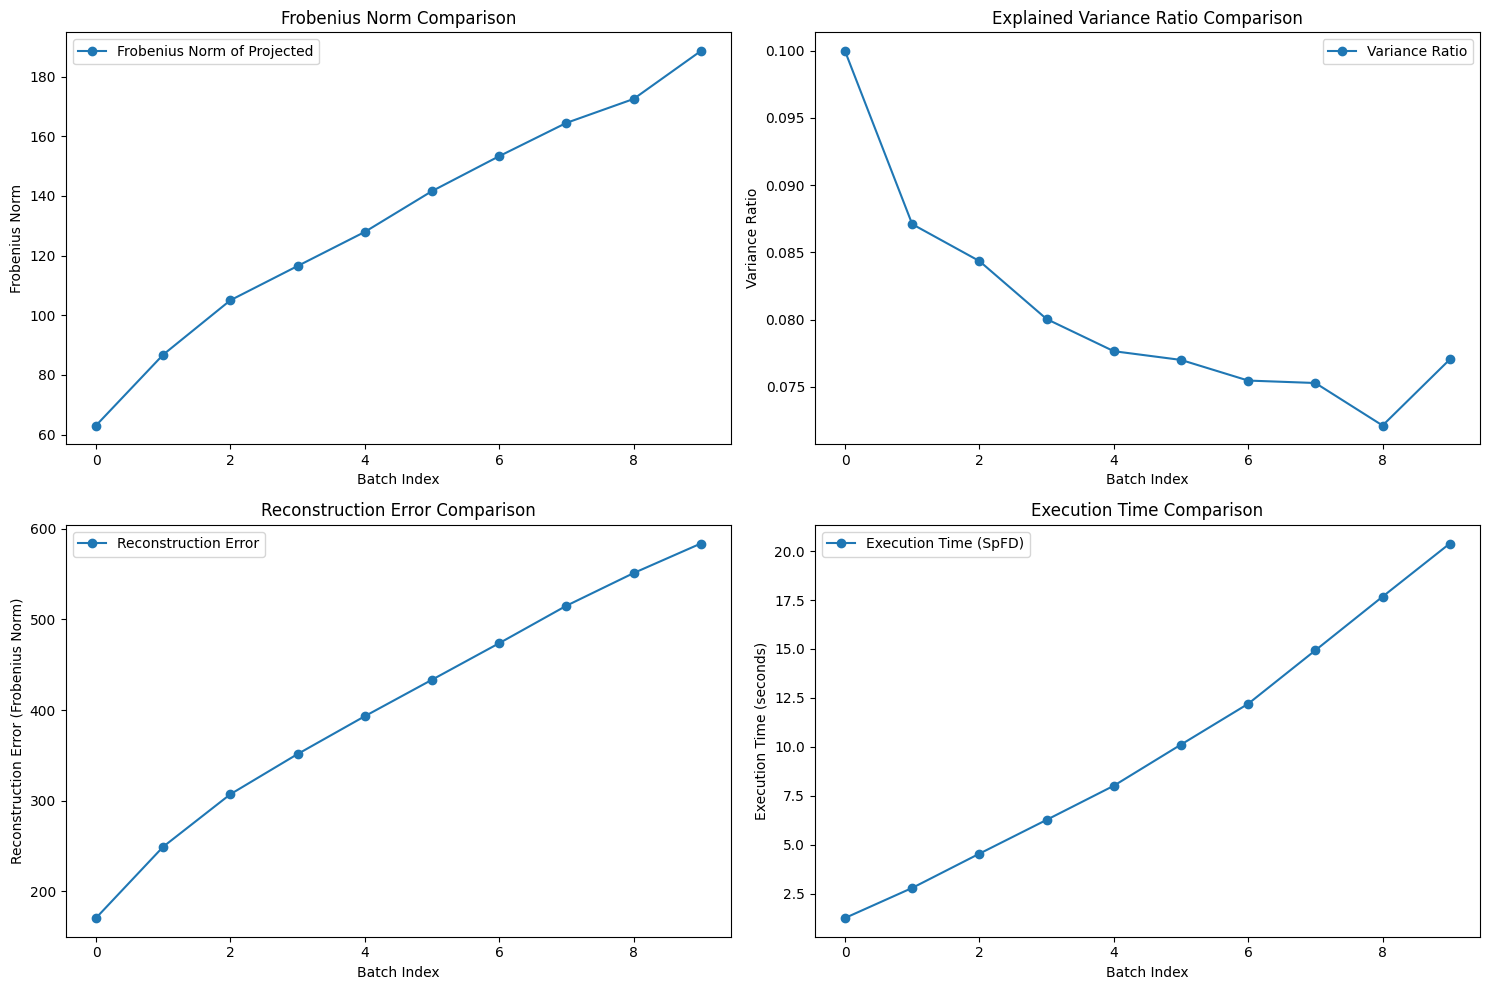

In [10]:
# -----------------------------------------------------------
# Sparse Embedding (SpEmb) and Frequent Directions (SpFD)
# -----------------------------------------------------------
# Implementation inspired by:
# D. Teng and D. Chu, "A Fast Frequent Directions Algorithm for Low Rank Approximation,"
# IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 41, no. 6, pp. 1279-1293, 1 June 2019,
# doi: 10.1109/TPAMI.2018.2839198
#
# Keywords:
# Approximation algorithms; Computational efficiency; Sparse matrices; Matrix decomposition;
# Singular value decomposition; Transforms; Data mining; Low rank approximation;
# Randomized algorithms; Frequent directions; Sparse subspace embedding

class SpEmb:
    """
    Sparse Embedding (SpEmb) for matrix sketching.
    """
    def __init__(self, sketch_size, rank_k, random_state=2020):
        self.ell = sketch_size
        self.k = rank_k
        self.rng = np.random.default_rng(random_state)

    def _sparse_embedding_matrix(self, n):
        """
        Create a sparse embedding matrix S of shape (ell, n)
        with random +1/-1 entries in a single position per column.
        """
        rows = self.rng.integers(low=0, high=self.ell, size=n)
        signs = self.rng.choice([-1, 1], size=n)
        S = np.zeros((self.ell, n))
        S[rows, np.arange(n)] = signs
        return S

    def fit_transform(self, A):
        """
        Fit the sketching model and return projected and reconstructed matrices.
        """
        n, d = A.shape
        S = self._sparse_embedding_matrix(n)
        B = S @ A

        # Compute orthonormal basis
        Q, _ = qr(B.T, mode='reduced')
        V = Q
        AV = A @ V

        # Compute truncated SVD on projected matrix
        U_k, s_k, Vt_k = svd(AV, full_matrices=False)
        A_tilde = (U_k[:, :self.k] @ np.diag(s_k[:self.k])) @ (Vt_k[:self.k, :] @ V.T)
        return AV[:, :self.k], A_tilde


class SpFD:
    """
    Sparse Frequent Directions (SpFD) matrix sketching.
    """
    def __init__(self, sketch_size, rank_k, num_blocks=5, random_state=2020):
        self.ell = sketch_size
        self.k = rank_k
        self.q = num_blocks
        self.rng = np.random.default_rng(random_state)

    def _sparse_embedding_matrix(self, n):
        """
        Sparse embedding matrix creation for each block.
        """
        rows = self.rng.integers(low=0, high=self.ell, size=n)
        signs = self.rng.choice([-1, 1], size=n)
        S = np.zeros((self.ell, n))
        S[rows, np.arange(n)] = signs
        return S

    def _spemb_block(self, A_block):
        """
        Apply SpEmb to a block of rows.
        """
        n_block = A_block.shape[0]
        S = self._sparse_embedding_matrix(n_block)
        return S @ A_block

    def fit_transform(self, A):
        """
        Fit the SpFD sketching model and return projected and reconstructed matrices.
        """
        n, d = A.shape
        perm = self.rng.permutation(n)
        A_perm = A[perm]

        # Initialize with first block
        B = self._spemb_block(A_perm[:n // self.q, :])

        # Process remaining blocks
        for i in range(1, self.q):
            block = A_perm[i*(n//self.q):(i+1)*(n//self.q), :]
            B_new = self._spemb_block(block)
            B = np.vstack((B, B_new))

            # Shrink using SVD
            U, s, Vt = svd(B, full_matrices=False)
            s_shrink = np.sqrt(np.maximum(s**2 - s[self.ell]**2, 0))
            B = (U[:, :self.ell] * s_shrink[:self.ell]) @ Vt[:self.ell, :]

        # Compute orthonormal basis
        Q, _ = qr(B.T, mode='reduced')
        V = Q
        AV = A @ V

        # Truncated SVD for final reconstruction
        U_k, s_k, Vt_k = svd(AV, full_matrices=False)
        A_tilde = (U_k[:, :self.k] @ np.diag(s_k[:self.k])) @ (Vt_k[:self.k, :] @ V.T)
        return AV[:, :self.k], A_tilde


# -----------------------------------------------------------
# Configuration
# -----------------------------------------------------------
K_DIM = 20
SKETCH_SIZE = 100
NUM_BLOCKS = 3
use_algorithm = "SpFD"  # Choose between "SpEmb" and "SpFD"

# Initialize model
if use_algorithm == "SpEmb":
    model = SpEmb(sketch_size=SKETCH_SIZE, rank_k=K_DIM)
else:
    model = SpFD(sketch_size=SKETCH_SIZE, rank_k=K_DIM, num_blocks=NUM_BLOCKS)

# -----------------------------------------------------------
# Metrics storage
# -----------------------------------------------------------
projected_SpFD = []
reconstructed_SpFD = []
fro_norms_SpFD = []
var_ratios_SpFD = []
rec_errors_SpFD = []
times_SpFD = []

cumulative_data = None

# -----------------------------------------------------------
# Process each batch
# -----------------------------------------------------------
for batch_index, batch_data in enumerate(tqdm(batches)):
    # Stack batches cumulatively
    if cumulative_data is None:
        cumulative_data = batch_data.values
    else:
        cumulative_data = np.vstack((cumulative_data, batch_data.values))

    # Timing
    start_time = time.time()
    projected, reconstructed = model.fit_transform(cumulative_data)
    end_time = time.time()

    # Store projected and reconstructed matrices
    projected_SpFD.append(projected)
    reconstructed_SpFD.append(reconstructed)

    # Cumulative execution time
    if len(times_SpFD) > 0:
        times_SpFD.append((end_time - start_time) + times_SpFD[-1])
    else:
        times_SpFD.append(end_time - start_time)

    # Compute metrics
    rec_error = np.linalg.norm(cumulative_data - reconstructed, 'fro')
    total_var = np.sum(np.var(cumulative_data, axis=0))
    projected_var = np.sum(np.var(projected, axis=0))
    var_ratio = projected_var / total_var

    fro_norms_SpFD.append(np.linalg.norm(projected, 'fro'))
    var_ratios_SpFD.append(var_ratio)
    rec_errors_SpFD.append(rec_error)

# -----------------------------------------------------------
# Plot Results
# -----------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Frobenius norm
axs[0][0].plot(range(len(batches)), fro_norms_SpFD, 'o-', label='Frobenius Norm of Projected')
axs[0][0].set_title('Frobenius Norm Comparison')
axs[0][0].set_xlabel('Batch Index')
axs[0][0].set_ylabel('Frobenius Norm')
axs[0][0].legend()

# Variance ratio
axs[0][1].plot(range(len(batches)), var_ratios_SpFD, 'o-', label='Variance Ratio')
axs[0][1].set_title('Explained Variance Ratio Comparison')
axs[0][1].set_xlabel('Batch Index')
axs[0][1].set_ylabel('Variance Ratio')
axs[0][1].legend()

# Reconstruction error
axs[1][0].plot(range(len(batches)), rec_errors_SpFD, 'o-', label='Reconstruction Error')
axs[1][0].set_title('Reconstruction Error Comparison')
axs[1][0].set_xlabel('Batch Index')
axs[1][0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axs[1][0].legend()

# Execution time
axs[1][1].plot(range(len(batches)), times_SpFD, 'o-', label=f'Execution Time ({use_algorithm})')
axs[1][1].set_title('Execution Time Comparison')
axs[1][1].set_xlabel('Batch Index')
axs[1][1].set_ylabel('Execution Time (seconds)')
axs[1][1].legend()

plt.tight_layout()
plt.show()

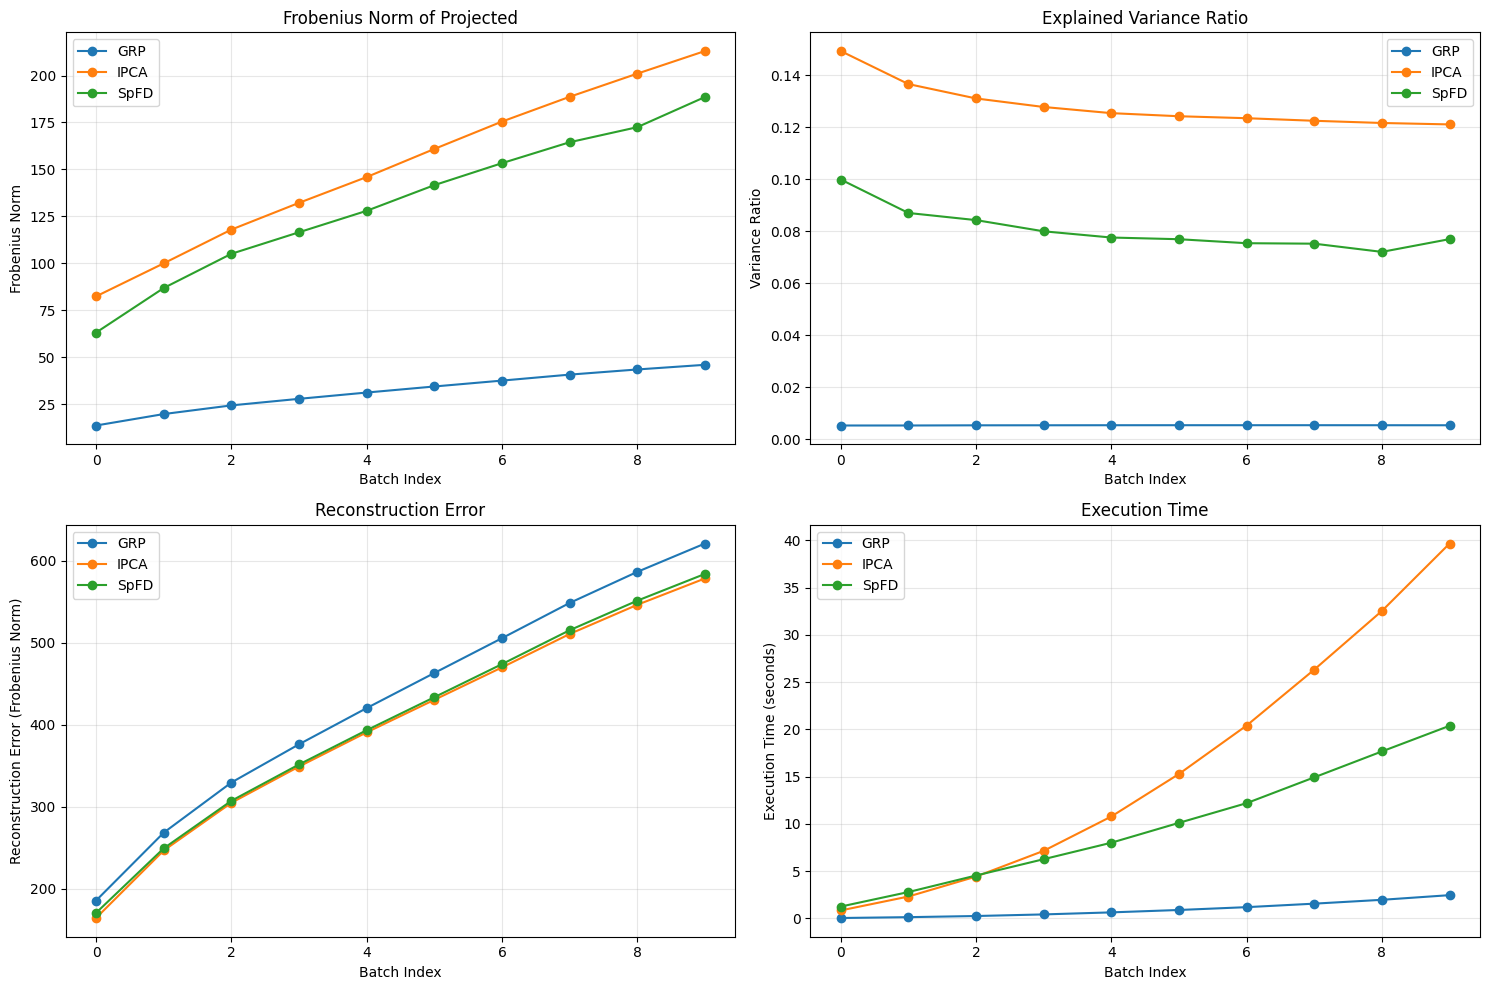

In [11]:
# -----------------------------------------------------------
# Compare GRP, IPCA, and SpFD across batches
# -----------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# -----------------------------
# Frobenius Norm of Projected Data
# -----------------------------
axs[0, 0].plot(range(len(batches)), fro_norms_grp, 'o-', label='GRP')
axs[0, 0].plot(range(len(batches)), fro_norms_ipca, 'o-', label='IPCA')
axs[0, 0].plot(range(len(batches)), fro_norms_SpFD, 'o-', label='SpFD')
axs[0, 0].set_title('Frobenius Norm of Projected')
axs[0, 0].set_xlabel('Batch Index')
axs[0, 0].set_ylabel('Frobenius Norm')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# -----------------------------
# Explained Variance Ratio
# -----------------------------
axs[0, 1].plot(range(len(batches)), var_ratios_grp, 'o-', label='GRP')
axs[0, 1].plot(range(len(batches)), var_ratios_ipca, 'o-', label='IPCA')
axs[0, 1].plot(range(len(batches)), var_ratios_SpFD, 'o-', label='SpFD')
axs[0, 1].set_title('Explained Variance Ratio')
axs[0, 1].set_xlabel('Batch Index')
axs[0, 1].set_ylabel('Variance Ratio')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# -----------------------------
# Reconstruction Error (Frobenius Norm)
# -----------------------------
axs[1, 0].plot(range(len(batches)), rec_errors_grp, 'o-', label='GRP')
axs[1, 0].plot(range(len(batches)), rec_errors_ipca, 'o-', label='IPCA')
axs[1, 0].plot(range(len(batches)), rec_errors_SpFD, 'o-', label='SpFD')
axs[1, 0].set_title('Reconstruction Error')
axs[1, 0].set_xlabel('Batch Index')
axs[1, 0].set_ylabel('Reconstruction Error (Frobenius Norm)')
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

# -----------------------------
# Cumulative Execution Time
# -----------------------------
axs[1, 1].plot(range(len(batches)), times_grp, 'o-', label='GRP')
axs[1, 1].plot(range(len(batches)), times_ipca, 'o-', label='IPCA')
axs[1, 1].plot(range(len(batches)), times_SpFD, 'o-', label='SpFD')
axs[1, 1].set_title('Execution Time')
axs[1, 1].set_xlabel('Batch Index')
axs[1, 1].set_ylabel('Execution Time (seconds)')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

In [12]:
# -----------------------------------------------------------
# Convert final projected results into pandas DataFrames
# -----------------------------------------------------------

# GRP (Gaussian Random Projection) final projection
df_projected_grp = pd.DataFrame(
    projected_grp[-1],               # Last batch projected matrix
    index=item_transaction_matrix.index  # Keep original transaction index
)

# IPCA (Incremental PCA with TensorFlow) final projection
df_projected_ipca = pd.DataFrame(
    projected_ipca[-1],
    index=item_transaction_matrix.index
)

# SpFD (Sparse Frequent Directions) final projection
df_projected_SpFD = pd.DataFrame(
    projected_SpFD[-1],
    index=item_transaction_matrix.index
)

# Display shapes for confirmation
print("GRP projected shape:", df_projected_grp.shape)
print("IPCA projected shape:", df_projected_ipca.shape)
print("SpFD projected shape:", df_projected_SpFD.shape)

GRP projected shape: (18434, 20)
IPCA projected shape: (18434, 20)
SpFD projected shape: (18434, 20)


In [13]:
# -----------------------------------------------------------
# Binarize Projected Matrices Based on Column Thresholds
# -----------------------------------------------------------
def binarize_projected(df, high_quantile=0.90):
    """
    Convert a projected continuous matrix into a binary matrix (presence/absence)
    based on per-column thresholds.

    Parameters:
    -----------
    df : pd.DataFrame
        Projected low-dimensional matrix.
    high_quantile : float
        High quantile to determine threshold for each column.

    Returns:
    --------
    bin_df : pd.DataFrame
        Boolean DataFrame where True indicates "significant" values.
    thresholds : pd.Series
        Threshold value used for each column.
    """
    thresholds = {}
    bin_df = pd.DataFrame(index=df.index)

    for col in df.columns:
        vals = df[col].to_numpy()
        abs_vals = np.abs(vals)

        if np.all(abs_vals == 0):
            mask = np.zeros_like(abs_vals, dtype=bool)
            t = np.nan
        else:
            # Use both IQR and quantile to set threshold
            q1, q3 = np.quantile(abs_vals, [0.25, 0.75])
            iqr = q3 - q1
            t_iqr = q3 + 1.5 * iqr
            t_q = np.quantile(abs_vals, high_quantile)
            t = max(t_iqr, t_q)

            if t <= 0:
                t = np.quantile(abs_vals, 0.999)  # fallback for near-zero values

            # Generate boolean mask
            mask = abs_vals >= t

        bin_df[col] = mask
        thresholds[col] = t
        
    return bin_df.astype(bool), pd.Series(thresholds)


# -----------------------------------------------------------
# Apply binarization to all projected matrices
# -----------------------------------------------------------
df_projected_ipca_bin, ipca_thresholds = binarize_projected(df_projected_ipca, high_quantile=0.90)
df_projected_grp_bin, grp_thresholds = binarize_projected(df_projected_grp, high_quantile=0.90)
df_projected_SpFD_bin, spfd_thresholds = binarize_projected(df_projected_SpFD, high_quantile=0.90)


# -----------------------------------------------------------
# Report Sparsity Metrics
# -----------------------------------------------------------
def report_sparsity(name, dfb):
    """
    Print sparsity statistics of a binarized DataFrame.

    Parameters:
    -----------
    name : str
        Name of the dataset/method.
    dfb : pd.DataFrame
        Boolean DataFrame after binarization.
    """
    col_rates = dfb.mean(axis=0)  # fraction of ones per column
    print(f"{name}: mean ones rate={col_rates.mean():.3f}, "
          f"median={col_rates.median():.3f}, "
          f"max={col_rates.max():.3f}, min={col_rates.min():.3f}")


# Display sparsity for each method
report_sparsity("IPCA-bin", df_projected_ipca_bin)
report_sparsity("GRP-bin", df_projected_grp_bin)
report_sparsity("SpFD-bin", df_projected_SpFD_bin)

IPCA-bin: mean ones rate=0.061, median=0.059, max=0.085, min=0.050
GRP-bin: mean ones rate=0.047, median=0.047, max=0.052, min=0.043
SpFD-bin: mean ones rate=0.058, median=0.056, max=0.100, min=0.045


Running FP-Growth on Original...
  Time: 1.03s, Patterns: 20
Running FP-Growth on GRP...
  Time: 0.03s, Patterns: 1
Running FP-Growth on IPCA...
  Time: 0.06s, Patterns: 19
Running FP-Growth on SpFD...
  Time: 0.06s, Patterns: 18


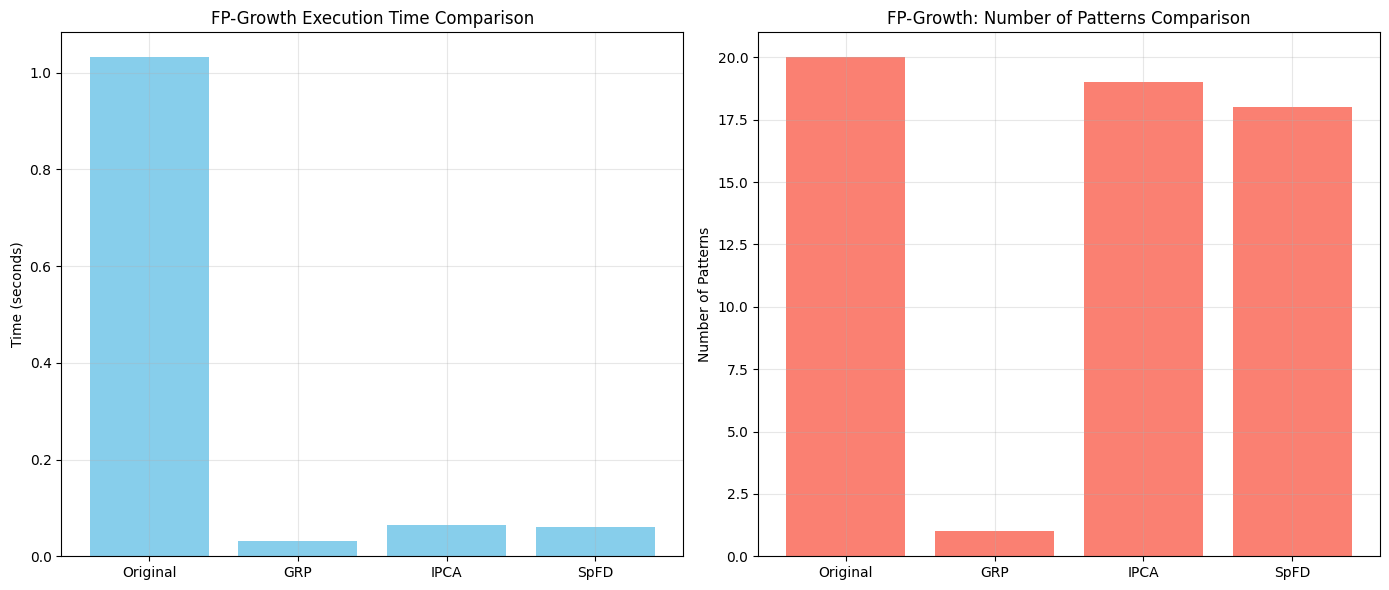

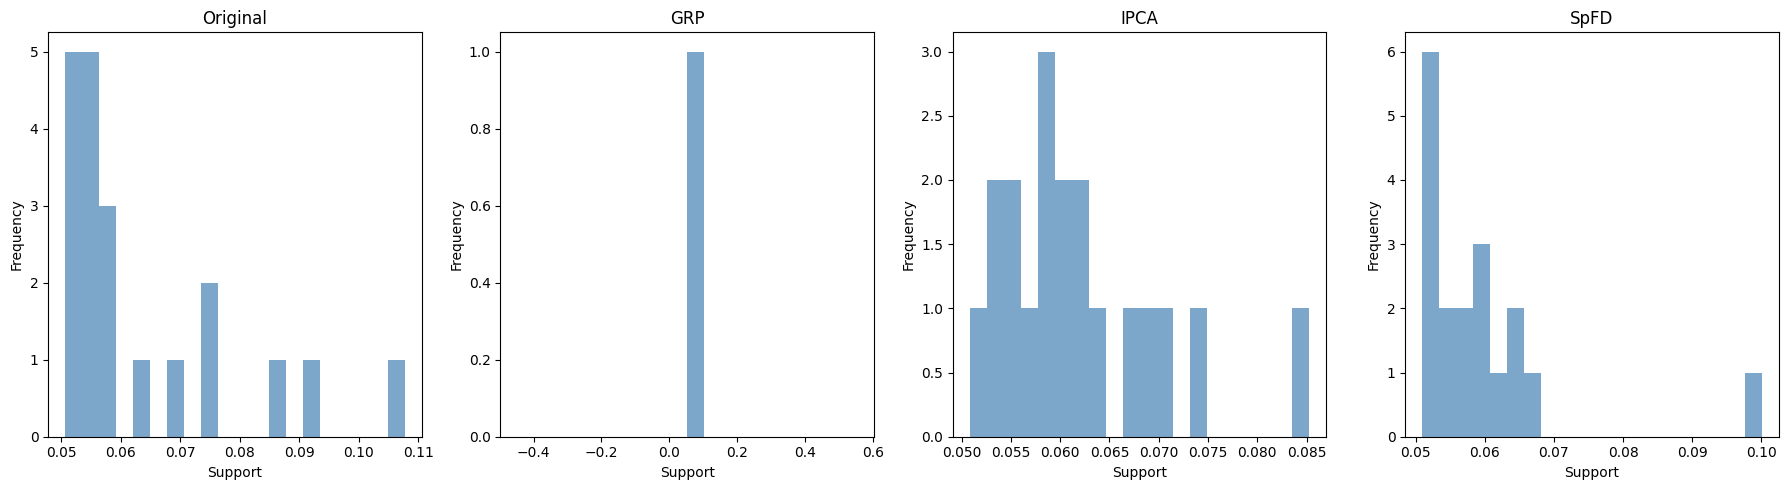


FP-Growth Summary Statistics:
  Original: Mean Support=0.0640, Median=0.0566, Max=0.1077, Min=0.0507
  GRP: Mean Support=0.0525, Median=0.0525, Max=0.0525, Min=0.0525
  IPCA: Mean Support=0.0618, Median=0.0598, Max=0.0853, Min=0.0508
  SpFD: Mean Support=0.0594, Median=0.0570, Max=0.1000, Min=0.0509


In [14]:
# -----------------------------------------------------------
# FP-Growth Frequent Pattern Mining on Original and Projected Matrices
# -----------------------------------------------------------

# Dictionary of matrices to analyze
matrices = {
    'Original': item_transaction_matrix,  # Original binary item-transaction matrix
    'GRP': df_projected_grp_bin,          # Binarized Gaussian Random Projection
    'IPCA': df_projected_ipca_bin,        # Binarized Incremental PCA
    'SpFD': df_projected_SpFD_bin         # Binarized Sparse Frequent Directions
}

# Minimum support threshold for frequent patterns
min_support = 0.05

# Store results
results = {}

# Run FP-Growth for each matrix
for mat_name, mat in matrices.items():
    print(f"Running FP-Growth on {mat_name}...")
    start_time = time.time()
    
    # Extract frequent itemsets
    freq_patterns = fpgrowth(mat, min_support=min_support, use_colnames=True)
    
    end_time = time.time()
    exec_time = end_time - start_time
    n_patterns = len(freq_patterns)
    
    # Store results
    results[mat_name] = {
        'time': exec_time,
        'n_patterns': n_patterns,
        'patterns': freq_patterns
    }
    
    print(f"  Time: {exec_time:.2f}s, Patterns: {n_patterns}")


# -----------------------------------------------------------
# Summary Bar Plots: Execution Time and Number of Patterns
# -----------------------------------------------------------
mat_names = list(matrices.keys())
times_data = [results[mat]['time'] for mat in mat_names]
n_patterns_data = [results[mat]['n_patterns'] for mat in mat_names]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Execution time comparison
axs[0].bar(mat_names, times_data, color='skyblue')
axs[0].set_title('FP-Growth Execution Time Comparison')
axs[0].set_ylabel('Time (seconds)')
axs[0].grid(True, alpha=0.3)

# Number of patterns comparison
axs[1].bar(mat_names, n_patterns_data, color='salmon')
axs[1].set_title('FP-Growth: Number of Patterns Comparison')
axs[1].set_ylabel('Number of Patterns')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# -----------------------------------------------------------
# Distribution of Support Values per Matrix
# -----------------------------------------------------------
fig, axs = plt.subplots(1, len(mat_names), figsize=(18, 5))

for i, mat_name in enumerate(mat_names):
    patterns = results[mat_name]['patterns']
    
    if not patterns.empty:
        axs[i].hist(patterns['support'], bins=20, alpha=0.7, color='steelblue')
        axs[i].set_title(f'{mat_name}')
        axs[i].set_xlabel('Support')
        axs[i].set_ylabel('Frequency')
    else:
        axs[i].text(0.5, 0.5, 'No patterns', ha='center', va='center', transform=axs[i].transAxes)
        axs[i].set_title(f'{mat_name}')

plt.tight_layout()
plt.show()


# -----------------------------------------------------------
# Detailed Summary Statistics
# -----------------------------------------------------------
print("\nFP-Growth Summary Statistics:")
for mat_name in mat_names:
    patterns = results[mat_name]['patterns']
    
    if not patterns.empty:
        mean_support = patterns['support'].mean()
        median_support = patterns['support'].median()
        max_support = patterns['support'].max()
        min_support = patterns['support'].min()
        print(f"  {mat_name}: Mean Support={mean_support:.4f}, "
              f"Median={median_support:.4f}, Max={max_support:.4f}, Min={min_support:.4f}")
    else:
        print(f"  {mat_name}: No patterns found")

Base anomalous pattern: [0.32311543 0.50755523 0.38693703 ... 0.32616936 0.53943965 0.37554824]
Injecting anomalies into batches: [6 5 8]
  - Injected 200 anomalous rows into batch 6.
  - Injected 200 anomalous rows into batch 5.
  - Injected 200 anomalous rows into batch 8.


Processing SpFD: 100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


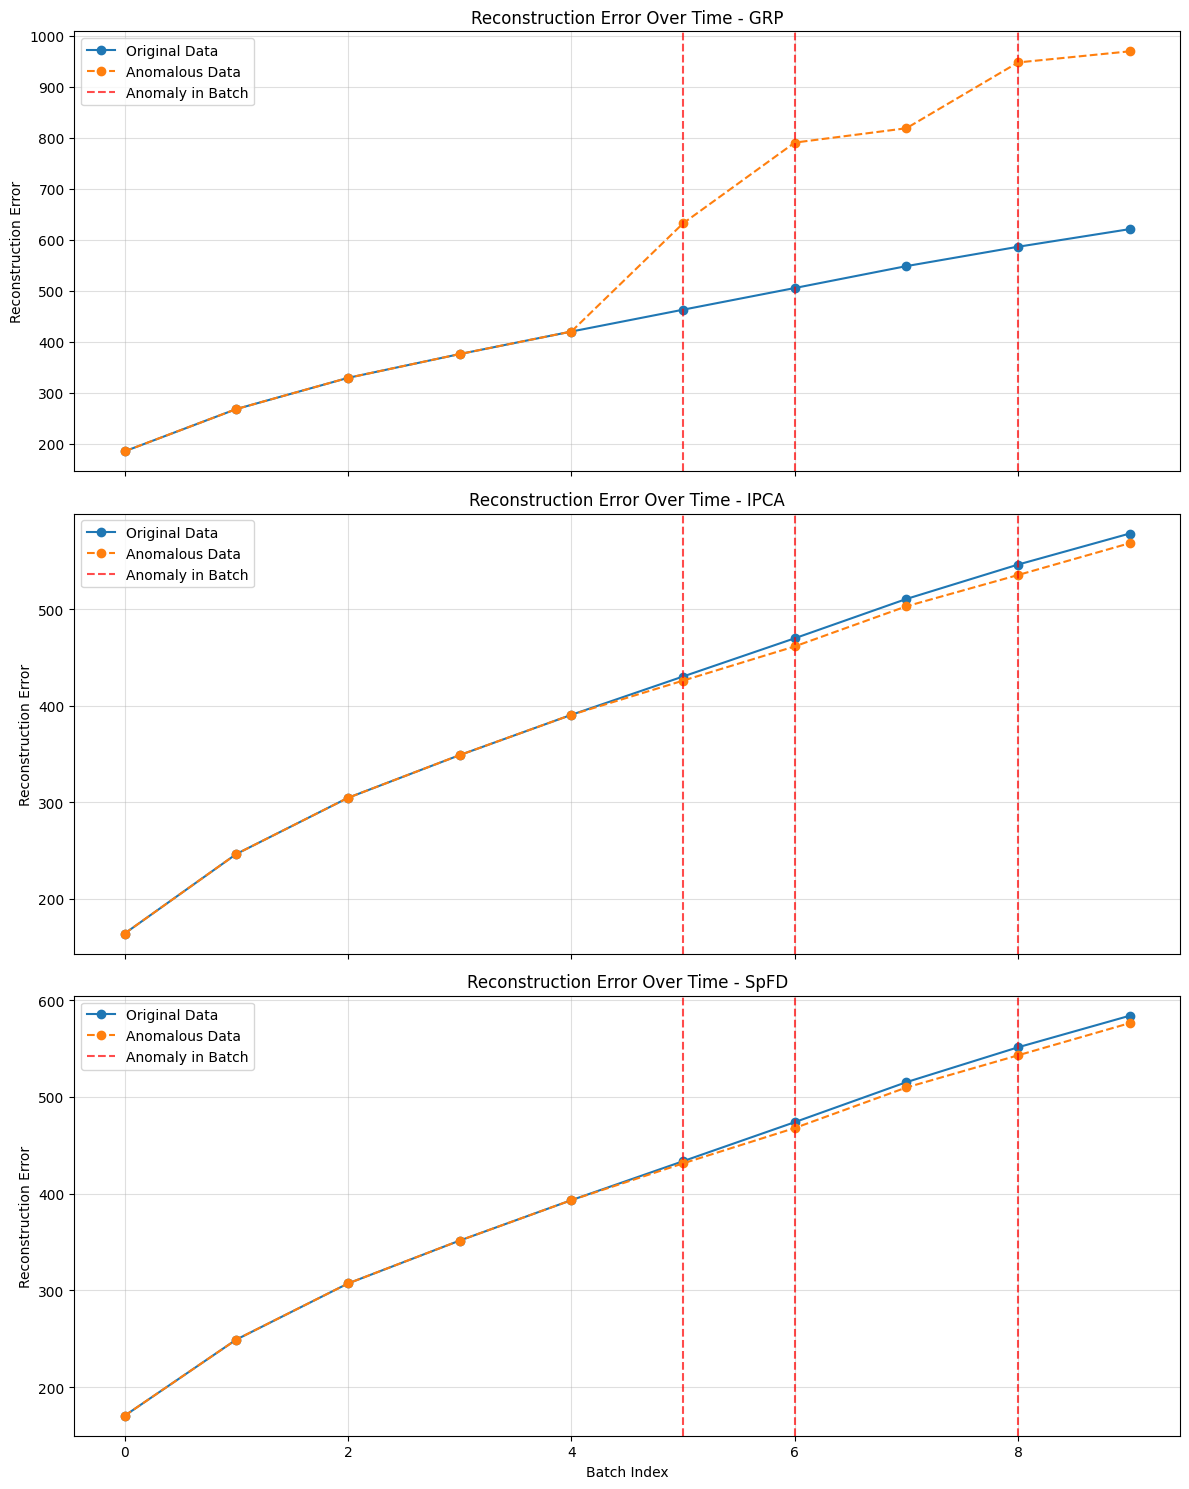

In [15]:
# -----------------------------------------------------------
# Step 1: Inject Synthetic Anomalies into Batches
# -----------------------------------------------------------

# Make a deep copy of batches to inject anomalies without altering original data
batches_with_anomalies = copy.deepcopy(batches)
anomaly_info = {}

np.random.seed(2020)

n_features = batches[0].shape[1]

# Create a "base" anomalous pattern with values sampled from a normal distribution
mean, std_dev = 0.5, 0.1
anomalous_pattern = np.random.normal(loc=mean, scale=std_dev, size=n_features)
anomalous_pattern = np.clip(anomalous_pattern, 0, 1)

print("Base anomalous pattern:", anomalous_pattern)

# Force a few feature indices to maximum value (1) to simulate strong anomalies
anomalous_indices = np.random.choice(n_features, 5, replace=False)
anomalous_pattern[anomalous_indices] = 1

# Randomly select batches to inject anomalies
n_anomalous_batches = 3
anomalous_batch_indices = np.random.choice(range(2, n_batches), n_anomalous_batches, replace=False)
print(f"Injecting anomalies into batches: {anomalous_batch_indices}")

# Inject anomalies into selected batches
for batch_idx in anomalous_batch_indices:
    batch_df = batches_with_anomalies[batch_idx]
    n_rows = batch_df.shape[0]
    
    n_anomalous_rows = 200  # number of rows in the batch to replace
    anomalous_row_indices = np.random.choice(n_rows, n_anomalous_rows, replace=False)
    
    anomaly_info[batch_idx] = anomalous_row_indices
    
    batch_df.iloc[anomalous_row_indices] = anomalous_pattern
    print(f"  - Injected {n_anomalous_rows} anomalous rows into batch {batch_idx}.")


# -----------------------------------------------------------
# Step 2: Function to Calculate Reconstruction Errors
# -----------------------------------------------------------
def calculate_reconstruction_errors(batches_data, model_logic, model_name):
    """
    Compute reconstruction error (Frobenius norm) for each batch.
    
    Parameters:
        batches_data : list of pd.DataFrame or tf.Tensor batches
        model_logic  : function that takes cumulative data and returns reconstructed matrix
        model_name   : 'GRP', 'IPCA', or 'SpFD' (handles TensorFlow conversion for IPCA)
    
    Returns:
        rec_errors   : list of reconstruction errors for each batch
    """
    rec_errors = []
    cumulative_data = None
    
    # Convert to TensorFlow tensors if using IPCA
    if model_name == 'IPCA':
        tf_batches_data = [tf.constant(b.values, dtype=tf.float32) for b in batches_data]
        data_iterator = tf_batches_data
    else:
        data_iterator = batches_data

    for batch_data in tqdm(data_iterator, desc=f"Processing {model_name}"):
        # Stack batches cumulatively
        current_batch_np = batch_data.values if hasattr(batch_data, 'values') else batch_data.numpy()
        if cumulative_data is None:
            cumulative_data = current_batch_np
        else:
            cumulative_data = np.vstack((cumulative_data, current_batch_np))
        
        # Reconstruct using the provided model logic
        reconstructed = model_logic(cumulative_data)
        
        # Compute Frobenius norm of reconstruction error
        error = np.linalg.norm(cumulative_data - reconstructed, 'fro')
        rec_errors.append(error)
        
    return rec_errors


# -----------------------------------------------------------
# Step 3: Define Reconstruction Functions for Each Sketching Method
# -----------------------------------------------------------
def grp_logic(data):
    _, reconstructed = gaussian_random_projection(data, k=K_DIM)
    return reconstructed

pca_tf_anom = TFIncrementalPCA(n_components=n_comp)
def ipca_logic(data):
    dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
    projected_tf, reconstructed_tf = [], []
    for batch in dataset:
        pca_tf_anom.partial_fit(batch)
        proj = pca_tf_anom.transform(batch)
        projected_tf.append(proj)
        reconstructed_tf.append(pca_tf_anom.inverse_transform(proj))
    return tf.concat(reconstructed_tf, axis=0).numpy()

spfd_model_anom = SpFD(sketch_size=SKETCH_SIZE, rank_k=K_DIM, num_blocks=NUM_BLOCKS)
def spfd_logic(data):
    _, reconstructed = spfd_model_anom.fit_transform(data)
    return reconstructed


# -----------------------------------------------------------
# Step 4: Compute Reconstruction Errors on Anomalous Batches
# -----------------------------------------------------------
rec_errors_grp_anom = calculate_reconstruction_errors(batches_with_anomalies, grp_logic, "GRP")
rec_errors_ipca_anom = calculate_reconstruction_errors(batches_with_anomalies, ipca_logic, "IPCA")
rec_errors_spfd_anom = calculate_reconstruction_errors(batches_with_anomalies, spfd_logic, "SpFD")


# -----------------------------------------------------------
# Step 5: Visualization of Reconstruction Errors
# -----------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Pair original vs anomalous errors
algorithms = {
    'GRP': (rec_errors_grp, rec_errors_grp_anom),
    'IPCA': (rec_errors_ipca, rec_errors_ipca_anom),
    'SpFD': (rec_errors_SpFD, rec_errors_spfd_anom)
}

for ax, (name, (original_err, anom_err)) in zip(axs, algorithms.items()):
    ax.plot(range(n_batches), original_err, 'o-', label='Original Data')
    ax.plot(range(n_batches), anom_err, 'o--', label='Anomalous Data')
    
    # Highlight batches where anomalies were injected
    for batch_idx in anomalous_batch_indices:
        ax.axvline(x=batch_idx, color='r', linestyle='--', alpha=0.7,
                   label='Anomaly in Batch' if batch_idx == anomalous_batch_indices[0] else "")
    
    ax.set_title(f'Reconstruction Error Over Time - {name}')
    ax.set_ylabel('Reconstruction Error')
    ax.legend()
    ax.grid(True, alpha=0.4)

axs[-1].set_xlabel('Batch Index')
plt.tight_layout()
plt.show()